## 첫번째 창 - 시장조류

- 시장의 추세를 파악하여 세가지 선택지(매수,매도,관망)중 한가지를 소거

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import sys
sys.path.append('C:/Users/Administrator/Desktop/stock_study/')

from Investar import Analyzer

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price("한컴위드", "2017-01-01")

end_date is initialized to '2021-01-10'


In [3]:
ema60 = df.close.ewm(span=60).mean()        # 종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean()      # 종가의 26주 지수 이동평균
macd = ema60 - ema130                       # MACD선
signal = macd.ewm(span=45).mean()           # 신호선(MACD선의 9주 지수 이동평균)
macdhist = macd - signal                    # MACD HIST

In [4]:
df = df.assign(ema130 = ema130, ema60 = ema60, macd = macd, signal = signal, macdhist= macdhist).dropna()
df["number"] = df.index.map(mdates.date2num)
ohlc = df[["number","open","high","low","close"]]

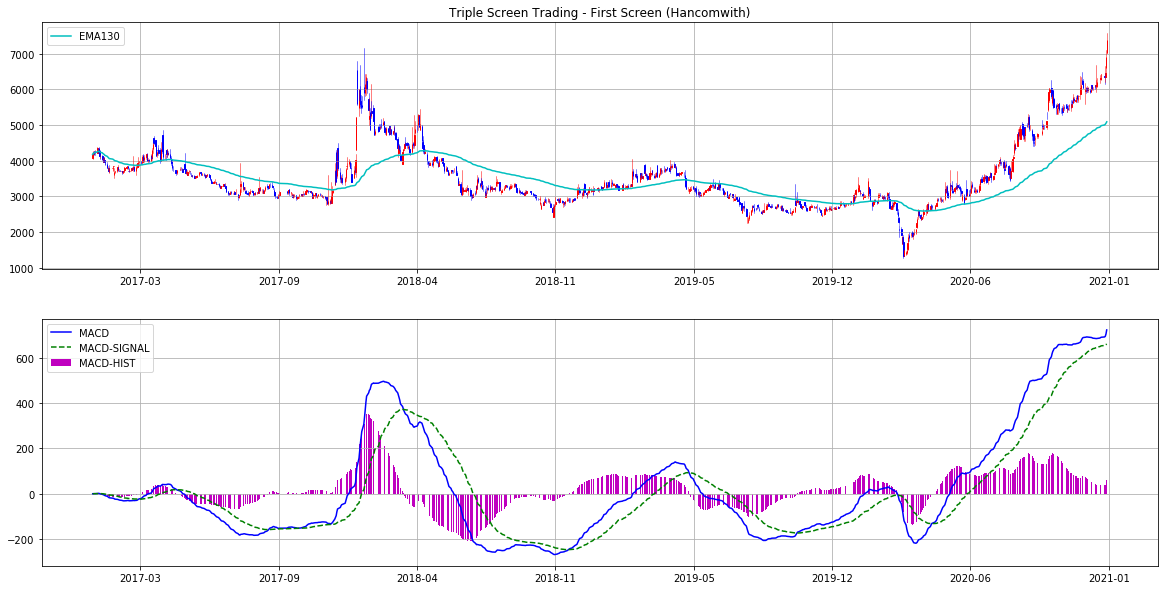

In [5]:
plt.figure(figsize=(20,10))

p1 = plt.subplot(211)
plt.title("Triple Screen Trading - First Screen (Hancomwith)")
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width =.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df.number, df.ema130, color = "c", label = "EMA130")
plt.legend(loc= "best")

p2 = plt.subplot(212)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.bar(df.number, df.macdhist, color = "m", label = "MACD-HIST")
plt.plot(df.number, df.macd, color = "b", label = "MACD")
plt.plot(df.number, df.signal, "g--", label = "MACD-SIGNAL")
plt.legend(loc= "best")
plt.show()

## 두번째 창 - 시장파도

- 시장의 추세 방향과 역행하는 파도를 파악하는데 오실레이터 이용

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import sys
sys.path.append('C:/Users/Administrator/Desktop/stock_study/')

from Investar import Analyzer

In [7]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price("한컴위드", "2017-01-01")

end_date is initialized to '2021-01-10'


In [8]:
ema60 = df.close.ewm(span=60).mean()        # 종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean()      # 종가의 26주 지수 이동평균
macd = ema60 - ema130                       # MACD선
signal = macd.ewm(span=45).mean()           # 신호선(MACD선의 9주 지수 이동평균)
macdhist = macd - signal                    # MACD HIST

In [9]:
df = df.assign(ema130 = ema130, ema60 = ema60, macd = macd, signal = signal, macdhist= macdhist).dropna()
df["number"] = df.index.map(mdates.date2num)
ohlc = df[["number","open","high","low","close"]]

In [10]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()   # 14일 단위로 고가를 자르고 그중 최댓값
ndays_low = df.low.rolling(window=14, min_periods=1).min()     # 14일 단위로 저가를 자르고 그중 최솟값
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100      # 스토캐스틱의 빠른선(%K)
slow_d = fast_k.rolling(window=3).mean()                              # 스토캐스틱의 느린선(%D) - 빠른선 3일동안 평균
df = df.assign(fast_k= fast_k, slow_d=slow_d).dropna()

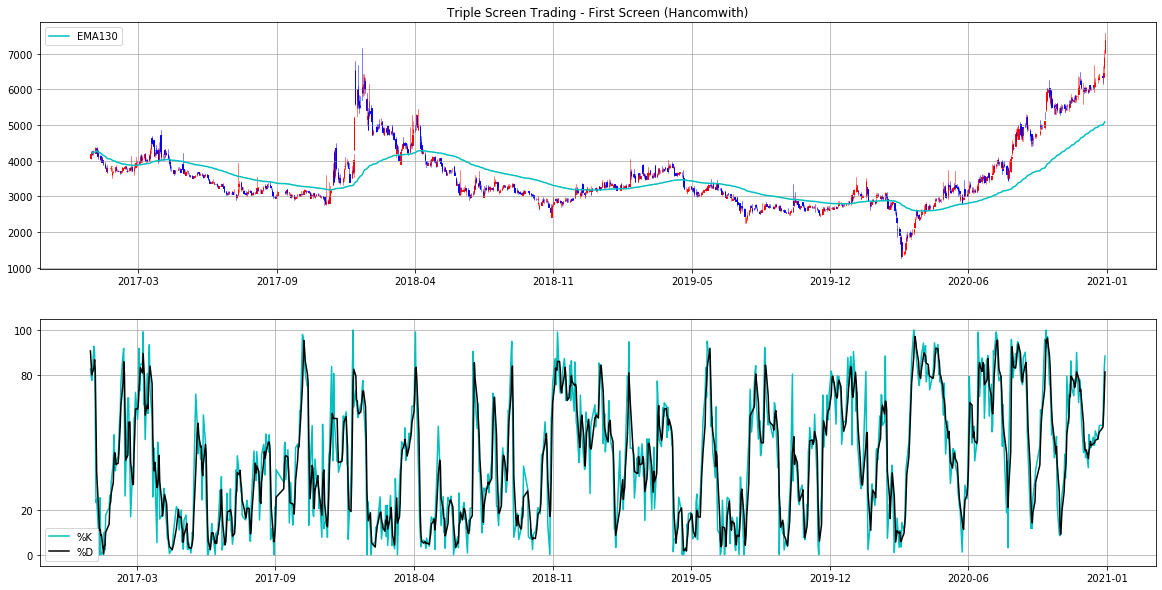

In [11]:
plt.figure(figsize=(20,10))

p1 = plt.subplot(211)
plt.title("Triple Screen Trading - First Screen (Hancomwith)")
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width =.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df.number, df.ema130, color = "c", label = "EMA130")
plt.legend(loc= "best")

p2 = plt.subplot(212)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df.number, df.fast_k, color = "c", label = "%K")
plt.plot(df.number, df.slow_d, color = "k", label = "%D")
plt.yticks([0, 20, 80, 100])
plt.legend(loc= "best")
plt.show()

## 세번째창 - 진입기술
- 주간 추세 상승 / 오실레이터 하락 -> 추적 매수 스탑
- 주간 추세 하락 / 오실레이터 상승 -> 추적 매도 스탑

|주간 추세|일간 오실레이터|행동|주문|
|:---|:---|:---|:---|
|상승|상승|관망| |
|상승|하락|매수|**추적 매수 스톱**|
|하락|상승|관망| |
|하락|상승|매도|**추적 매도 스톱**|

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import sys
sys.path.append('C:/Users/Administrator/Desktop/stock_study/')

from Investar import Analyzer

In [13]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price("한컴위드", "2017-01-01")

end_date is initialized to '2021-01-10'


In [15]:
ema60 = df.close.ewm(span=60).mean()        # 종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean()      # 종가의 26주 지수 이동평균
macd = ema60 - ema130                       # MACD선
signal = macd.ewm(span=45).mean()           # 신호선(MACD선의 9주 지수 이동평균)
macdhist = macd - signal                    # MACD HIST
df = df.assign(ema130 = ema130, ema60 = ema60, macd = macd, signal = signal, macdhist= macdhist).dropna()

In [16]:
df["number"] = df.index.map(mdates.date2num)
ohlc = df[["number","open","high","low","close"]]

In [17]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()   # 14일 단위로 고가를 자르고 그중 최댓값
ndays_low = df.low.rolling(window=14, min_periods=1).min()     # 14일 단위로 저가를 자르고 그중 최솟값
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100      # 스토캐스틱의 빠른선(%K)
slow_d = fast_k.rolling(window=3).mean()                              # 스토캐스틱의 느린선(%D) - 빠른선 3일동안 평균
df = df.assign(fast_k= fast_k, slow_d=slow_d).dropna()

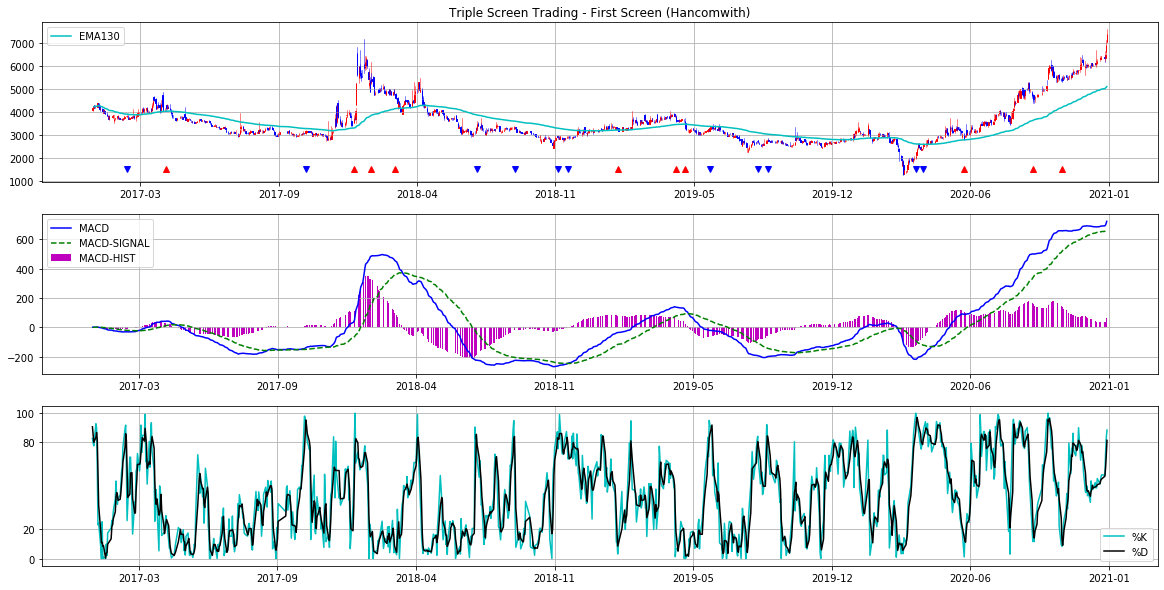

In [18]:
plt.figure(figsize=(20,10))

p1 = plt.subplot(311)
plt.title("Triple Screen Trading - First Screen (Hancomwith)")
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width =.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df.number, df.ema130, color = "c", label = "EMA130")
for i in range(1, len(df.close)):
    if df.ema130.values[i-1] < df.ema130.values[i] and df.slow_d.values[i-1] >= 20 and df.slow_d.values[i] < 20:
        plt.plot(df.number.values[i],1500,'r^')
    elif df.ema130.values[i-1] > df.ema130.values[i] and df.slow_d.values[i-1] <= 80 and df.slow_d.values[i] > 80:
        plt.plot(df.number.values[i],1500,'bv')
plt.legend(loc= "best")

p2 = plt.subplot(312)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.bar(df.number, df.macdhist, color = "m", label = "MACD-HIST")
plt.plot(df.number, df.macd, color = "b", label = "MACD")
plt.plot(df.number, df.signal, "g--", label = "MACD-SIGNAL")
plt.legend(loc= "best")


p3 = plt.subplot(313)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df.number, df.fast_k, color = "c", label = "%K")
plt.plot(df.number, df.slow_d, color = "k", label = "%D")
plt.yticks([0, 20, 80, 100])
plt.legend(loc= "best")
plt.show()